In [105]:
import MetaTrader5 as mt5
from tqdm import tqdm
import time

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay

from datetime import datetime, timedelta
from itertools import combinations, count

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller

from hurst import compute_Hc

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [50]:
# get all symbols from the location specified
def get_symbols(location):
    mt5.initialize()

    symbol_list = []
    for symbol in mt5.symbols_get():
        if location in symbol.path:
            symbol_list.append(symbol.name)

    return symbol_list

In [51]:
# For start_date to end_date get the 1 hour ticker info for symbol
def get_bars_from_broker(symbol, start_date, end_date, timeframe=mt5.TIMEFRAME_H1):
    mt5.initialize()
    bars = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    df_bars = pd.DataFrame(bars)
    df_bars["time"] = pd.to_datetime(df_bars["time"], unit="s")
    return df_bars

In [52]:
mt5.initialize()

True

In [53]:
# How many days worth of data to consider
LOOKBACK = 30

end_date = datetime.now() + timedelta(hours=3) # The '+ timedelta(hours=3)' is here because of some unknown time-lag issues with metatrader5
start_date = end_date - BDay(LOOKBACK)

In [54]:
# 1 Get Asset Universe
location = "Retail\\Stocks\\UK"

In [55]:
# Create a list of all available tradable assets in the chosen location
symbol_list = []
for symbol in mt5.symbols_get():
    if location in symbol.path:
        symbol_list.append(symbol.name)

In [56]:
symbol_close_data = {}
# For each symbol
for symbol in tqdm(symbol_list):
    # get the OHLC data from the broker
    bar_data = get_bars_from_broker(symbol, start_date, end_date)

    # Store the data locally so we dont have to request the same
    # data from the broker everytime we use it. 
    bar_data.to_csv(f'historic_data/{symbol}.csv', index=False)

  0%|          | 0/173 [00:00<?, ?it/s]

100%|██████████| 173/173 [00:03<00:00, 54.88it/s]


In [57]:
# Specify the basket size
BASKET_SIZE = 2 # Here we keep the basket to pairs as otherwise without parallelization it becomes too computationally expensive

# Create a new list whose elements are pairs of assets
symbol_basket_collection = list(combinations(symbol_list, BASKET_SIZE))
print(f'The collection has {len(symbol_basket_collection)} baskets of assets')

The collection has 14878 baskets of assets


In [58]:
def check_cointegration(symbol_basket, total_baskets):
    # Read the OHLC data from CSV files
    data = [pd.read_csv(f'historic_data/{symbol}.csv') for symbol in symbol_basket]

    ##########################################################
    # This section equalizes the length of the time series

    # Find the minimum length among the dataframes
    min_length = min(len(df) for df in data)

    # Truncate dataframes to the minimum length
    data = [df.head(min_length) for df in data]

    # Update CSV files if required
    
    for symbol, df in zip(symbol_basket, data):
        df.to_csv(f'historic_data/{symbol}.csv', index=False)

    ##########################################################

    # Extract the close prices
    close_prices = np.column_stack([df['close'] for df in data])

    # Apply Johansen test
    johansen_test = coint_johansen(close_prices, det_order=0, k_ar_diff=1)

    # Standard alpha value 
    alpha = 0.05

    # Adjust alpha for Bonferroni correction
    bonferroni_alpha = alpha / total_baskets

    # Check cointegration using the Bonferroni-adjusted alpha
    is_cointegrated = any(johansen_test.lr1 > johansen_test.cvt[:, 1]) and (1 - bonferroni_alpha) > 0.95

    # Get the cointegration coefficients (eigenvectors)
    cointegration_coefficients = johansen_test.evec[:, 0]

    return is_cointegrated, cointegration_coefficients.tolist()

In [59]:
def find_cointegrated_assets(symbol_baskets_collection):
    cointegrated_assets = []
    total_baskets = len(symbol_baskets_collection)
    
    for basket in tqdm(symbol_baskets_collection):

        # return (Boolean, List<COEFF>) 
        is_cointegrated, coefficients = check_cointegration(basket, total_baskets)

        # If they are cointegrated
        if is_cointegrated:

            # Load their OHLC
            data = [pd.read_csv(f'historic_data/{symbol}.csv') for symbol in basket]

            # Create the (stationary) time series from their close data using the cointegration coefficients
            combined_asset = sum(df['close'] * coeff for df, coeff in zip(data, coefficients))

            # append to the list of cointegrated assets
            cointegrated_assets.append((basket, combined_asset))
            
    return cointegrated_assets

In [60]:
cointegrated_assets = find_cointegrated_assets(symbol_basket_collection)

100%|██████████| 14878/14878 [05:30<00:00, 45.05it/s]


In [61]:
def test_stationarity_of_assets(cointegrated_assets):
    stationary_assets = []

    for asset in tqdm(cointegrated_assets):
        asset_name, time_series = asset

        # Applying the ADF test
        result = adfuller(time_series)

        # Extracting the p-value
        p_value = result[1]

        # Stationarity criteria: p-value should be less than or equal to 0.05
        if p_value <= 0.05:
            stationary_assets.append((asset_name, time_series))

    return stationary_assets

In [62]:
stationary_assets = test_stationarity_of_assets(cointegrated_assets)

100%|██████████| 2950/2950 [00:13<00:00, 225.82it/s]


In [63]:
def hurst_exponent(time_series):
    
    # Define the range of lags
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]

    # To avoid divide by zero error, add a small constant to tau values
    tau = np.array(tau) + 1e-10

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # The Hurst exponent is half of the slope of the linear fit
    return poly[0] * 0.5

def check_mean_reversion(stationary_assets):
    
    mean_reverting_assets = []

    for asset in tqdm(stationary_assets):
        asset_name, time_series = asset

        # Calculate the Hurst exponent for the time series
        H = hurst_exponent(time_series)

        # Check if the Hurst exponent indicates mean reversion (0 < H < 0.5)
        if 0 < H < 0.5:
            mean_reverting_assets.append(asset)

    return mean_reverting_assets

In [64]:
mean_reverting_assets = check_mean_reversion(stationary_assets)

100%|██████████| 1763/1763 [01:01<00:00, 28.49it/s]


In [74]:
def calculate_half_life(time_series):
    # Prepare the data for linear regression
    ts_diff = np.diff(time_series)
    ts_lagged = time_series[:-1]

    # Perform linear regression
    ts_lagged_const = add_constant(ts_lagged)
    model = OLS(ts_diff, ts_lagged_const)
    result = model.fit()

    # Calculate theta from the regression coefficient
    theta = -result.params[1]

    # Calculate and return half-life
    half_life = np.log(2) / theta
    return half_life

def calculate_half_lives(mean_reverting_assets):
    results = []

    for asset in mean_reverting_assets:
        asset_name, time_series = asset

        # Calculate half-life
        half_life = calculate_half_life(time_series)
        results.append((asset_name, time_series, half_life))

    return results

In [75]:
half_life_assets = calculate_half_lives(mean_reverting_assets)

In [78]:
def find_fastest_half_life_asset(half_life_assets):
    if not half_life_assets:
        return None

    # Initialize with the first asset's data
    fastest_asset = half_life_assets[0]

    for asset in half_life_assets:
        _, _, half_life = asset

        # Compare with the current minimum half-life
        if half_life < fastest_asset[2]:
            fastest_asset = asset

    return fastest_asset

In [79]:
fastest_half_life_asset = find_fastest_half_life_asset(half_life_assets)

In [103]:
def plot_asset(asset):
    # Unpack the asset data
    asset_name, time_series, _ = asset

    # Plotting the time series
    # plt.figure(figsize=(10, 6))
    
    plt.plot(time_series, label=f'{asset_name} Time Series')

    plt.axhline(time_series.mean(), color='g')
    
    plt.axhline(time_series.mean() + time_series.std(), color='y')
    plt.axhline(time_series.mean() - time_series.std(), color='y')
    
    plt.axhline(time_series.mean() + 2 * time_series.std(), color='r')
    plt.axhline(time_series.mean() - 2 * time_series.std(), color='r')

    plt.title(f'Time Series Plot for {asset_name}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

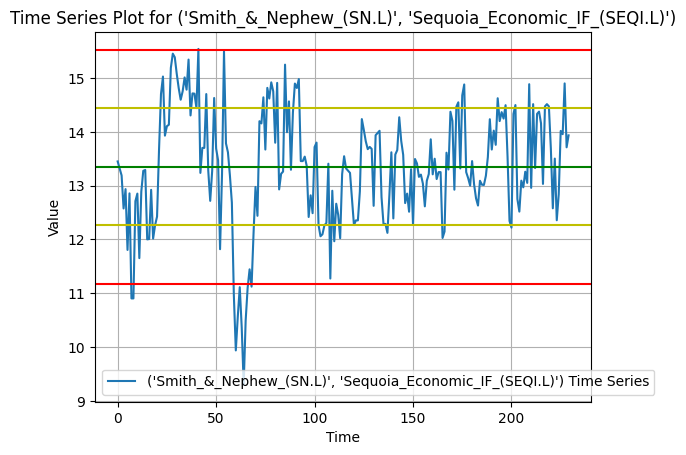

In [104]:
plot_asset(fastest_half_life_asset)

In [106]:
def lstm_forecast(time_series, half_life):
    # Preprocess the time series
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_series = scaler.fit_transform(np.array(time_series).reshape(-1, 1))

    # Prepare data for LSTM
    def create_dataset(dataset, time_step):
        X, y = [], []
        for i in range(len(dataset) - time_step - 1):
            a = dataset[i:(i + time_step), 0]
            X.append(a)
            y.append(dataset[i + time_step, 0])
        return np.array(X), np.array(y)

    time_step = int(half_life)
    X, y = create_dataset(scaled_series, time_step)

    # Reshape input to be [samples, time steps, features]
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X, y, epochs=100, batch_size=32)

    # Forecasting
    forecast_length = int(half_life)
    forecast = []
    current_batch = scaled_series[-time_step:]

    for i in range(forecast_length):
        current_pred = model.predict(current_batch.reshape(1, time_step, 1))
        forecast.append(current_pred[0, 0])
        current_batch = np.append(current_batch[1:], current_pred)

    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

In [107]:
_, time_series, half_life = fastest_half_life_asset
forecast = lstm_forecast(time_series, half_life)

Epoch 1/100
8/8 [==============================] - 4s 6ms/step - loss: 0.4220
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 0.3298
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 0.2044
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0604
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0413
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0314
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0248
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0260
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0245
Epoch 11/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 12/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0246
Epoch 13/100
8/8 [==============================] - 0s 4ms/st